### Imports

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from bb_rhythm import utils
import matplotlib
import sys
from pathlib import Path
sys.path.append(str(Path("figure_panel_1.ipynb").resolve().parents[1]))
import path_settings

matplotlib.rcParams.update({"font.size": 5,
                            "ytick.major.size": 1,
                            "ytick.major.width": 0.4,
                            "xtick.major.size": 1,
                            "xtick.major.width": 0.4,
                            "font.sans-serif": "Arial"})

In [13]:
def convert_phase_to_hours(phase, period=24):
    return - period * phase / (2 * np.pi) * (24 / period) + 12


def plot_grid(grid, var, sim=False, save_to=None, alpha_grid=None,
              thresh=None, ax=None, vertex_depth=False):
    
    # Convert phase from rad to time of day.
    if var == "phase":
        period = 400 if sim else 24
        grid = convert_phase_to_hours(grid, period)
        
    label_dict = {"phase": "Hour of peak activity",
                  "depth": "Avg. vertex depth"}
    
    cmap = "viridis_r" if var == "phase" else "viridis"
    tick_dist = 10 if var == "depth" else 100
    
    if type(alpha_grid) == np.ndarray:
        alpha_grid[np.isnan(alpha_grid)] = 0
        alpha_grid /= np.max(alpha_grid)
        alpha_grid[alpha_grid >= thresh] = 1
        alpha_grid[alpha_grid < thresh] = 0.1
        alpha_grid = np.flip(alpha_grid, axis=0)
    
    # Flip for origin to be in lower left coner.
    if not sim:
        grid = np.flip(grid, axis=0)
    
    plt.figure(figsize=(3.5, 1.7), dpi=300)
    sns.heatmap(grid, xticklabels=tick_dist, yticklabels=tick_dist, square=True, ax=None,
                cmap=cmap, cbar=True, cbar_kws={"label":label_dict[var], "shrink":0.7},
                robust=True, linewidths=0, rasterized=True, alpha=alpha_grid)
    plt.xlabel("x position [mm]")
    plt.ylabel("y position [mm]")
    
    # Correct for metric if using differen resolution.
    if vertex_depth:
        plt.xticks(ticks=plt.xticks()[0], labels=10*np.array(plt.xticks()[0], dtype=int))
        plt.yticks(ticks=plt.yticks()[0], labels=10*np.array(plt.yticks()[0], dtype=int))
    
    plt.gca().invert_yaxis()
    
    if sim:
        plt.scatter([6,177], [6,102], c=["black", "white"], marker="x", s=12)
    
    if save_to:
        plt.savefig(save_to, bbox_inches="tight")

### Phase per location

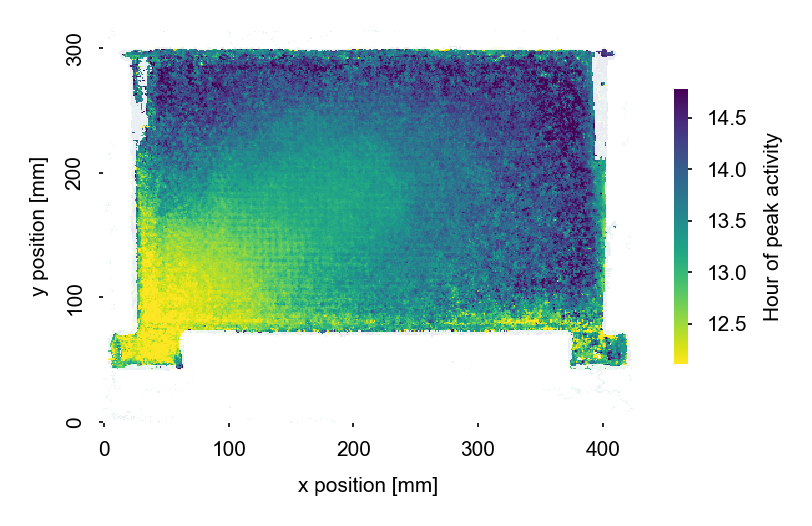

In [4]:
year = 2019
phase_grid = np.load(os.path.join(os.pardir, "aggregated_results", str(year), "phase_per_loc_%d.npy" % year))
phase_grid_count = np.load(os.path.join(os.pardir, "aggregated_results", str(year), "phase_count_per_loc_%d.npy" % year))

plot_grid(phase_grid, "phase", sim=False, alpha_grid=phase_grid_count,
          thresh=0.01, save_to=os.path.join("imgs", "phase_per_loc_%d.svg" % year))

### Simulated phase per location

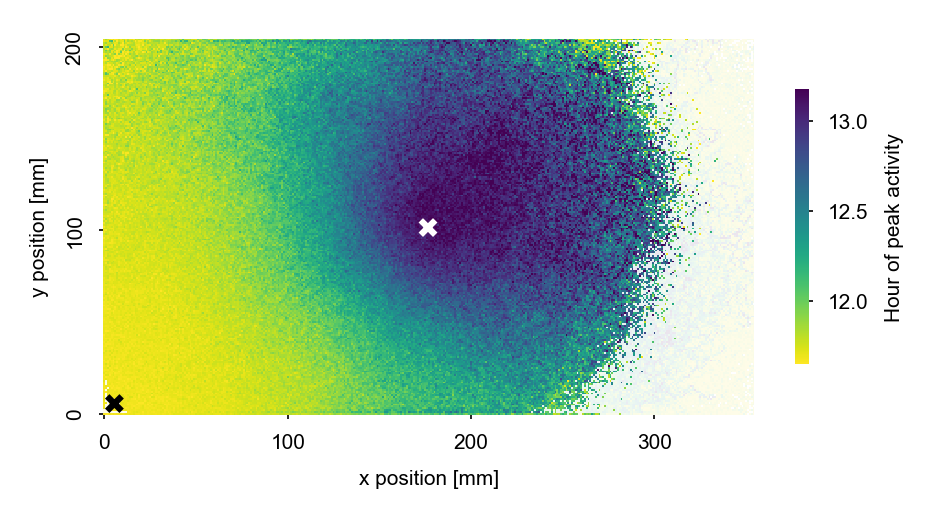

In [17]:
phase_grid = np.load(os.path.join(os.pardir, "aggregated_results", "simulation", "phase_per_loc_simulated.npy"))
phase_grid_count = np.load(os.path.join(os.pardir, "aggregated_results", "simulation", "phase_count_per_loc_simulated.npy"))

plot_grid(phase_grid, "phase", sim=True, alpha_grid=phase_grid_count,
          thresh=0.01, save_to=os.path.join("imgs", "phase_per_loc_sim.svg"))

### Node depth per location

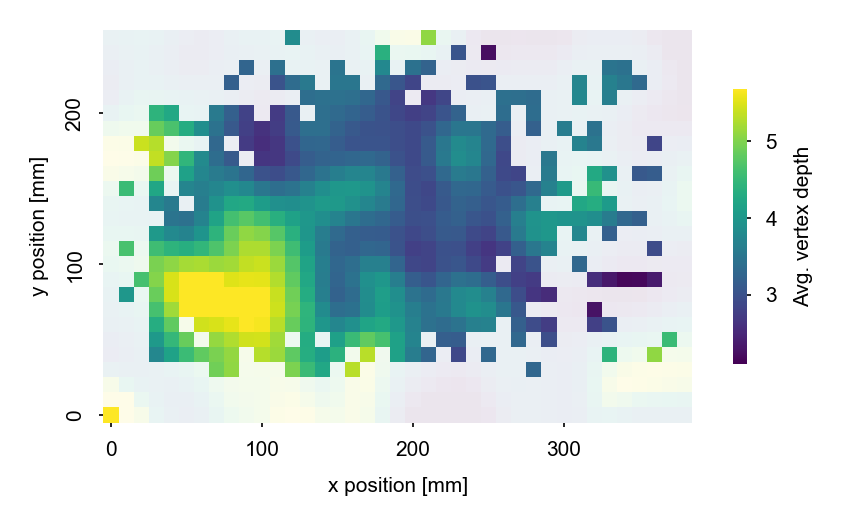

In [6]:
def get_vertex_depth_per_loc(path_df):
    path_df[["x_pos", "y_pos"]] = (path_df.loc[:,["x_pos", "y_pos"]] / 10).round().astype(int)
    
    vertex_depth_grid = pd.pivot_table(path_df, index="y_pos", aggfunc="median",
                                       columns="x_pos", values="depth").to_numpy()
    vertex_depth_grid_count = pd.pivot_table(path_df, index="y_pos", aggfunc="count",
                                       columns="x_pos", values="depth").to_numpy()
    
    vertex_depth_grid = utils.nan_tolerant_gaussian_filtering(vertex_depth_grid, 1.5)
    
    return vertex_depth_grid, vertex_depth_grid_count

# Read data.
# path = path_settings.INTERACTION_TREE_DF_PATH_2019
path = "../../data/interaction_tree_paths_2019.csv"
path_df = pd.read_csv(path, index_col = 0)

# Calculate median vertex depth and count per location.
vertex_depth_grid, vertex_depth_grid_count = get_vertex_depth_per_loc(path_df)

# Plot.
plot_grid(vertex_depth_grid, "depth", sim=False, alpha_grid=vertex_depth_grid_count,
          thresh=0.01, save_to=os.path.join("imgs", "vertex_depth_per_loc_2019.svg"),
          vertex_depth=True)

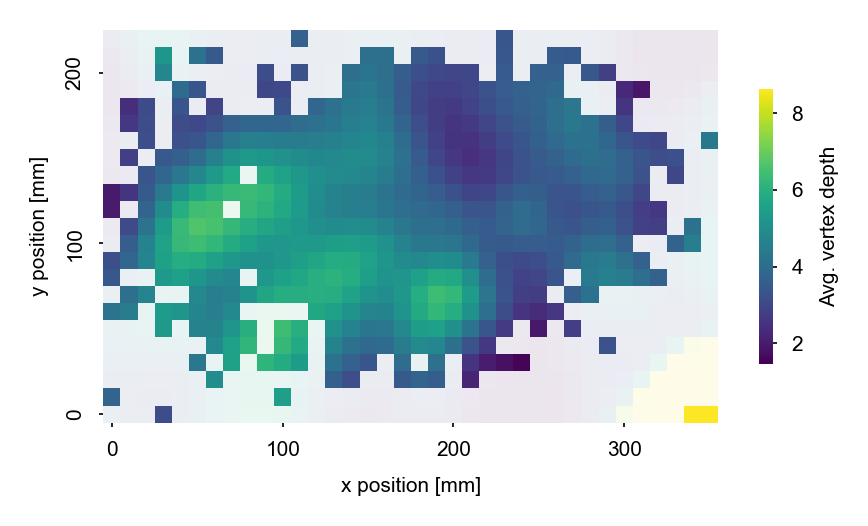

In [7]:
# Read data.
# path = path_settings.INTERACTION_TREE_DF_PATH_2016
path = "../../data/interaction_tree_paths_2016.csv"
path_df = pd.read_csv(path, index_col=0)

# Calculate median vertex depth and count per location.
vertex_depth_grid, vertex_depth_grid_count = get_vertex_depth_per_loc(path_df)

# Plot.
plot_grid(vertex_depth_grid, "depth", sim=False, alpha_grid=vertex_depth_grid_count,
          thresh=0.0001, save_to=os.path.join("imgs", "vertex_depth_per_loc_2016.svg"),
          vertex_depth=True)

### Distribution of parameters at roots and leafs of interaction trees

In [ ]:
from scipy.stats import brunnermunzel

# Raed data.
path_df = pd.read_csv(path_settings.INTERACTION_TREE_DF_PATH_2019, parse_dates=["datetime", "time_gap"])
cosinor_df = pd.read_csv(path_settings.COSINOR_DF_PATH_2019,
                         usecols=["phase", "age", "r_squared", "date", "bee_id"],
                         parse_dates=["date"])
path_df.dropna(inplace=True)

# Get bee and date combinations.
path_df["date"] = path_df.datetime.dt.date
cosinor_df["date"] = cosinor_df.date.dt.date
path_df["bee_day"] = list(zip(path_df.bee_id, path_df.date))
cosinor_df["bee_day"] = list(zip(cosinor_df.bee_id, cosinor_df.date))

# Remove leafs from cosinor df.
leafs = np.unique(path_df.loc[path_df.is_leaf, "bee_day"])
cosinor_df = cosinor_df.loc[~cosinor_df.bee_day.isin(leafs)]

# Convert phase to hours.
cosinor_df["phase"] = ((-24 * cosinor_df["phase"] / (2 * np.pi)) + 12) % 24

for i, var in enumerate(["phase", "age", "r_squared"]):
    
    # Select distribution of selected parameter for leaf vertices.
    leaf_dist = path_df.loc[path_df.is_leaf, var]
    
    # Select baseline distribution of selected parameter.
    total_dist = cosinor_df[var]
    
    # Print Brunner-Munzel test results.
    print(var)
    alternative = "less" if var == "phase" else "greater"
    print(brunnermunzel(leaf_dist, total_dist, nan_policy="omit", distribution="normal"))
    print()

phase
BrunnerMunzelResult(statistic=21.607864462286056, pvalue=0.0)

age
BrunnerMunzelResult(statistic=-12.354439190333446, pvalue=4.609594532204374e-35)

r_squared
BrunnerMunzelResult(statistic=3.8137619280396082, pvalue=0.00013686732105977484)



### Speed change per loaction and time

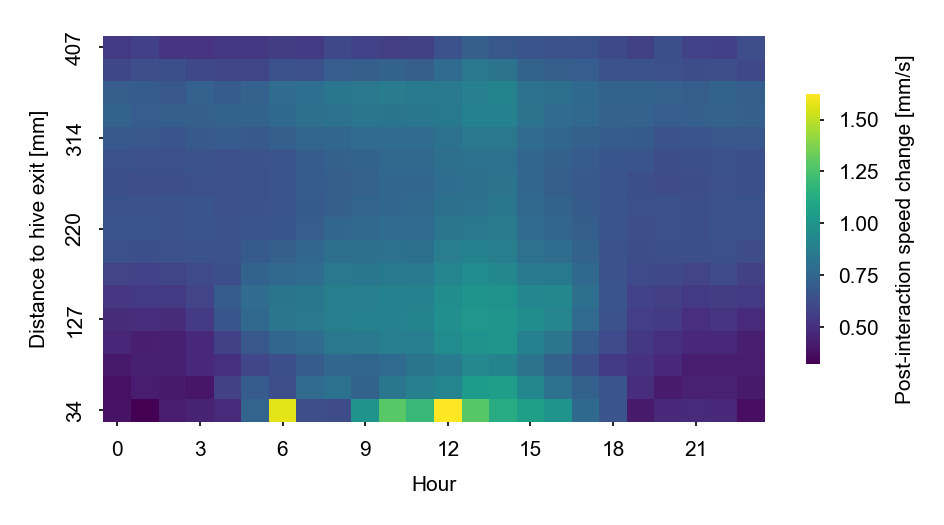

In [18]:
def heatmap_vel_ch_vs_dist(year, save_to=None):
    
    pivot = pd.read_pickle(os.path.join(os.pardir, "aggregated_results", str(year), "vel_change_per_dist_and_hour_grid.pkl"))
    pivot = pivot.iloc[:-1]

    # Plot.
    plt.figure(figsize=(3.15, 1.7), dpi=300)
    sns.heatmap(pivot, xticklabels=3, yticklabels=4,
                cbar_kws={"label": "Post-interaction speed change [mm/s]", "shrink":0.7},
                robust=False, square=False, cmap="viridis", linewidths=0, rasterized=True)
    plt.gca().invert_yaxis()
    plt.ylabel("Distance to hive exit [mm]")
    plt.xlabel("Hour")
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    plt.show()

year = 2016
heatmap_vel_ch_vs_dist(year, os.path.join("imgs", "vel_change_vs_dist_%d.svg" % year))